In [1]:
# --- Environment Setup for Colab ---
import os
import subprocess
import sys
import numpy as np
import cv2
import json
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import ast

from scipy.ndimage import binary_fill_holes
import torch
import torchvision;
assert torch.cuda.is_available(), "CUDA GPU is required."

# 1a. Install required dependencies
!{sys.executable} -m pip install opencv-python scikit-image matplotlib git+https://github.com/facebookresearch/sam2.git --quiet
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.utils.amg import calculate_stability_score

# 1b.
!git clone https://github.com/andrew-noonan/Bubble-Segmentation-SAM2.git


# 2. Mount Google Drive (if not already mounted)
drive_path = "/content/drive"
if not os.path.exists(drive_path):
    from google.colab import drive
    drive.mount(drive_path)

# 3. Make directory for model checkpoints
!mkdir -p ../checkpoints/


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'Bubble-Segmentation-SAM2' already exists and is not an empty directory.


## Function Definitions

In [56]:
# --- Impoty Utility Functions ---
!rm -rf Bubble-Segmentation-SAM2
!git clone https://github.com/andrew-noonan/Bubble-Segmentation-SAM2.git

sys.path.append('/content/Bubble-Segmentation-SAM2/src')


import importlib

# Optional: flag to control reloading
RELOAD_HELPERS = True

if RELOAD_HELPERS:
    import segmentation
    import visualization
    import analysis

    importlib.reload(segmentation)
    importlib.reload(visualization)
    importlib.reload(analysis)

    from segmentation import (
        sobel_edge,
        generate_boxes_and_points,
        multi_scale_box_masks,
        watershed_split,
        should_split,
        filter_contained_masks
    )

    from analysis import (
        compute_props,
        summarize_props
    )

    from visualization import (
        plot_detected_circles,
        plot_mask_stages,
        visualize_prompts_on_image
    )

from segmentation import (
    sobel_edge,
    generate_boxes_and_points,
    multi_scale_box_masks,
    watershed_split,
    should_split,
    filter_contained_masks
)

from analysis import (
    compute_props,
    summarize_props
)

from visualization import (
    plot_detected_circles,
    plot_mask_stages
)

def load_sam2_model(model_choice="tiny"):
    """
    Load SAM2 model of the specified size.

    Parameters:
        model_choice (str): One of "tiny", "small", "base_plus", or "large".

    Returns:
        sam2 model instance (torch.nn.Module)
    """
    base_ckpt_path = "../checkpoints"
    cfg_dir = "configs/sam2.1"

    sam2_models = {
        "tiny":       ("sam2.1_hiera_tiny.pt",      "sam2.1_hiera_t.yaml"),
        "small":      ("sam2.1_hiera_small.pt",     "sam2.1_hiera_s.yaml"),
        "base_plus":  ("sam2.1_hiera_base_plus.pt", "sam2.1_hiera_b.yaml"),
        "large":      ("sam2.1_hiera_large.pt",     "sam2.1_hiera_l.yaml")
    }

    sam2_urls = {
        "tiny":      "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt",
        "small":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt",
        "base_plus": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt",
        "large":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
    }

    ckpt_file, cfg_file = sam2_models[model_choice]
    ckpt_path = os.path.join(base_ckpt_path, ckpt_file)
    cfg_path = os.path.join(cfg_dir, cfg_file)

    if not os.path.exists(ckpt_path):
        print(f"[INFO] Checkpoint '{ckpt_file}' not found. Downloading...")
        subprocess.run(["wget", "-P", base_ckpt_path, sam2_urls[model_choice]], check=True)
    else:
        print(f"[INFO] Checkpoint '{ckpt_file}' found.")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = build_sam2(cfg_path, ckpt_path, device=device, apply_postprocessing=False)
    print(f"[INFO] Loaded SAM2 model: {model_choice} on {device}")
    return model

import itertools
def getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials):
    """
    Generate valid experiment folder paths based on parameter combinations.
    Only returns paths that exist on the filesystem.

    Folder structure:
    {angle} Degree/{temp}F/{aeration}_Percent Trial {trial}/{flow}
    """
    all_combinations = list(itertools.product(angles, temps, aeration_rates, trials, flowRates))
    all_dirs = []

    for angle, temp, aeration, trial, flow in all_combinations:
        aeration_str = str(aeration).replace('.', '_')
        flow_str = str(flow).replace('.', '_')

        rel_path = f"{angle} Degree/{temp}F/{aeration_str} Percent Trial {trial}/{flow_str}"
        full_path = os.path.join(basePath, rel_path)
        # print(full_path)
        if os.path.exists(full_path):
            all_dirs.append(full_path)

    print(f"Found {len(all_dirs)} valid directories out of {len(all_combinations)} total combinations.")
    return all_dirs



# --- Main Batch Runner ---
import json

def run_batch_on_experiments(
    base_dir,
    predictor,
    test_mode=False,
    test_mode_frames=3,
    iou_threshold=0.91,
    stability_threshold=0.91,
    peak_filter_size=15,
    min_region_area=200,
    max_region_area=10000,
    edge_thresh=0.95,
    min_contour_len=10,
    pad_ratios= [0.0, 0.4, 1.0, 1.3]):

    exp_path = os.path.join(base_dir, "3 - Normalized")
    print(exp_path)
    if not os.path.exists(exp_path):
        print(f"Experiment Directory not found: {exp_path}")
        return

    props_all = []
    per_frame_props = {}
    frame_count = 0

    for fname in sorted(os.listdir(exp_path)):
        if test_mode and frame_count >= test_mode_frames:
            print("Reached test frame limit, stopping.")
            break
        if not test_mode and frame_count >= 50:
            print("Reached 50 frame limit, stopping.")
            break
        if not fname.lower().endswith(".png"):
            continue

        img_path = os.path.join(exp_path, fname)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        sobel = sobel_edge(image)
        boxes, all_pts = generate_boxes_and_points(image, sobel,edge_thresh, min_contour_len)
        predictor.set_image(image)

        if test_mode:
          plt.subplot(1, 2, 1)
          plt.imshow(image)
          plt.title("Original Image")
          plt.axis("off")

          plt.subplot(1, 2, 2)
          plt.imshow(sobel, cmap='gray')
          plt.title(f"Sobel Magnitude")
          plt.axis("off")

        #plt.show(sobel)
        anns_initial = []
        anns_filtered = []
        anns_filled = []
        anns_split = []

        visualize_prompts_on_image(image,boxes,all_pts)
        # 1. Get raw SAM masks
        for box, pts in zip(boxes, all_pts):
            mask, iou, logits = multi_scale_box_masks(predictor, image, box, pts[0],pad_ratios)
            mask = mask > predictor.mask_threshold
            anns_initial.append(mask)

            stab = float(calculate_stability_score(
                torch.as_tensor(logits[None, None]),
                predictor.mask_threshold, threshold_offset=1.0)[0])

            if iou >= iou_threshold and stab >= stability_threshold:
                anns_filtered.append((mask, iou, stab, box, pts))

        # 2. Fill and pre-filter before splitting
        anns = []
        for mask, iou, stab, box, pts in anns_filtered:
            filled_mask = binary_fill_holes(mask).astype(bool)
            anns.append({
                "segmentation": filled_mask,
                "area": int(filled_mask.sum()),
                "bbox": None,  # will recompute later
                "predicted_iou": iou,
                "point_coords": pts,
                "stability_score": stab,
                "crop_box": box,
            })
            anns_filled.append(filled_mask)

        # 3. Filter contained before splitting
        anns_contained = filter_contained_masks(anns, containment_thresh=0.6)

        # 4. Apply splitting
        final_anns = []
        for ann in anns_contained:
            filled_mask = ann["segmentation"]

            do_split = should_split(filled_mask)
            split_masks = watershed_split(filled_mask, peak_filter_size, min_region_area, max_region_area) if do_split else []

            if split_masks:
                for sm in split_masks:
                    labeled = label(sm.astype(int))
                    for region in regionprops(labeled):
                        if region.area < min_region_area:
                            continue
                        y0, x0, y1, x1 = region.bbox
                        bbox = [x0, y0, x1 - x0, y1 - y0]
                        region_mask = (labeled == region.label)

                        new_ann = ann.copy()
                        new_ann["segmentation"] = region_mask
                        new_ann["bbox"] = bbox
                        new_ann["area"] = int(region_mask.sum())
                        final_anns.append(new_ann)
                        anns_split.append(region_mask)
            else:
                # ✅ Fallback: Always preserve original if split fails
                props = regionprops(label(filled_mask.astype(int)))
                if not props:
                    continue
                region = props[0]
                y0, x0, y1, x1 = region.bbox
                ann["bbox"] = [x0, y0, x1 - x0, y1 - y0]
                ann["area"] = int(filled_mask.sum())
                final_anns.append(ann)
                anns_split.append(filled_mask)


        # 5. Final props + visualization
        props = compute_props([a["segmentation"] for a in final_anns])
        props_all.extend(props)

        if props:
            per_frame_props[fname] = props

        if test_mode:
            masks_dict = {
                "initial": anns_initial,
                "filtered": [a[0] for a in anns_filtered],
                "contained": [a["segmentation"] for a in anns_contained],
                "split": anns_split,
                "final": [a["segmentation"] for a in final_anns],  # for circle plotting only
            }
            plot_mask_stages(image, masks_dict, props, title_prefix=fname)
            plot_detected_circles(image, props, circularity_thresh=0.8)


        frame_count += 1
        if frame_count % 5 == 0:
            print(f"Through {frame_count} frames")

    summary = summarize_props(props_all)
    summary_path = os.path.join(base_dir, "experiment_summary.csv")
    pd.DataFrame([summary]).to_csv(summary_path, index=False)

    props_json_path = os.path.join(base_dir, "per_frame_props.json")
    with open(props_json_path, 'w') as f:
        json.dump(per_frame_props, f, indent=2)

    print(f"Finished processing {frame_count} frames.")




Cloning into 'Bubble-Segmentation-SAM2'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 148 (delta 39), reused 129 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 37.24 MiB | 22.39 MiB/s, done.
Resolving deltas: 100% (39/39), done.


## Define Constants

In [78]:
# --- Constants ---
iou_threshold = 0.91          # Cutoff for SAM2 mask iou values
stability_threshold = 0.91    # Cutoff for SAM2 mask stability values
pad_ratios = [0.0, 1.0, 1.5]  # For multi-scale  box generation
min_contour_len = 10          # For determining valid boxes from Sobel
min_region_area = 20         # For watershed distance transform
max_region_area = 100000       # For watershed distance transform
peak_filter_size = 10         # For watershed distance transform
edge_thresh = 0.5

Found 1 valid directories out of 1 total combinations.
[INFO] Checkpoint 'sam2.1_hiera_tiny.pt' found.
[INFO] Loaded SAM2 model: tiny on cuda

Processing 1 of 1: /content/drive/MyDrive/Master's Data Processing/Post-Thesis Data/30 Degree/180F/0_2 Percent Trial 3/4_5
/content/drive/MyDrive/Master's Data Processing/Post-Thesis Data/30 Degree/180F/0_2 Percent Trial 3/4_5/3 - Normalized


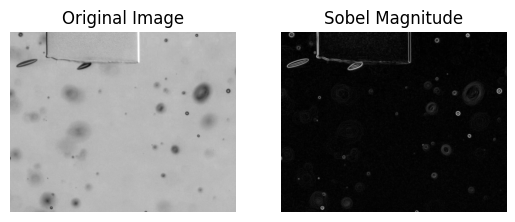

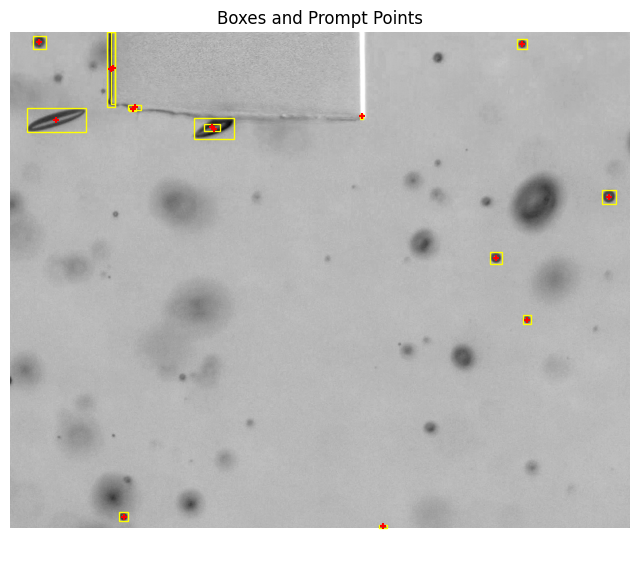

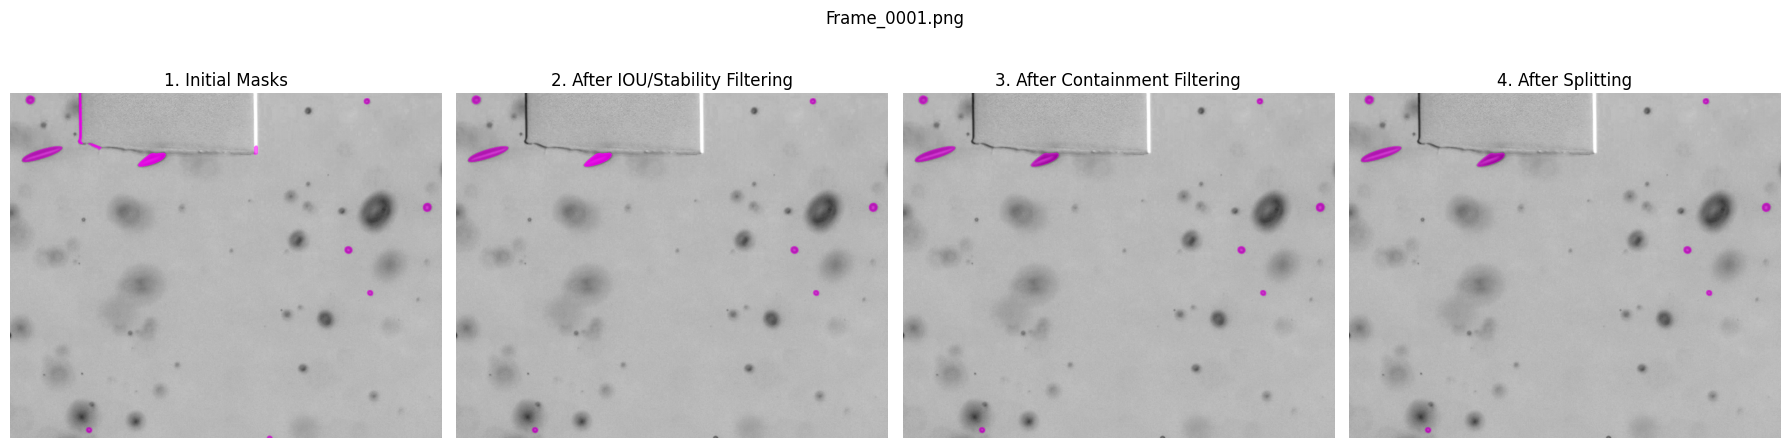

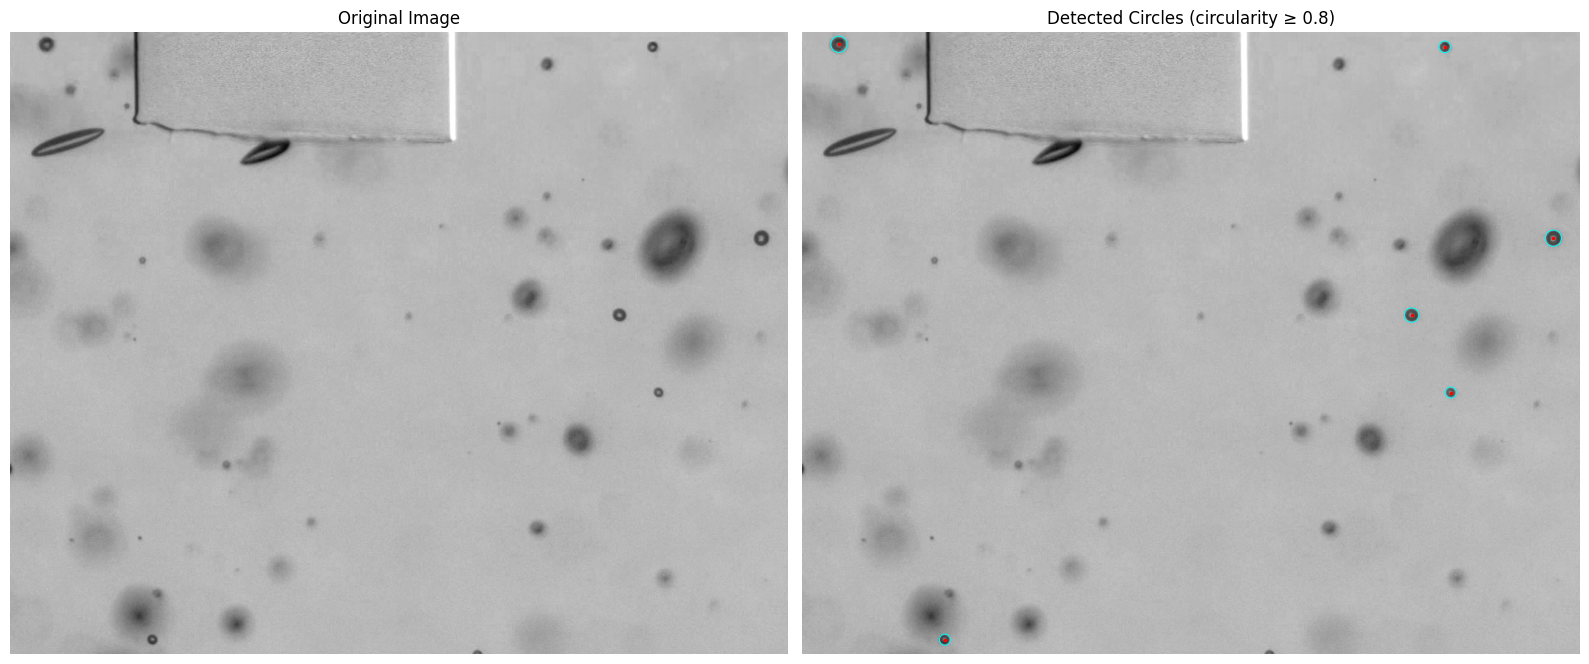

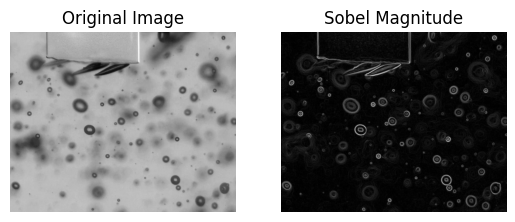

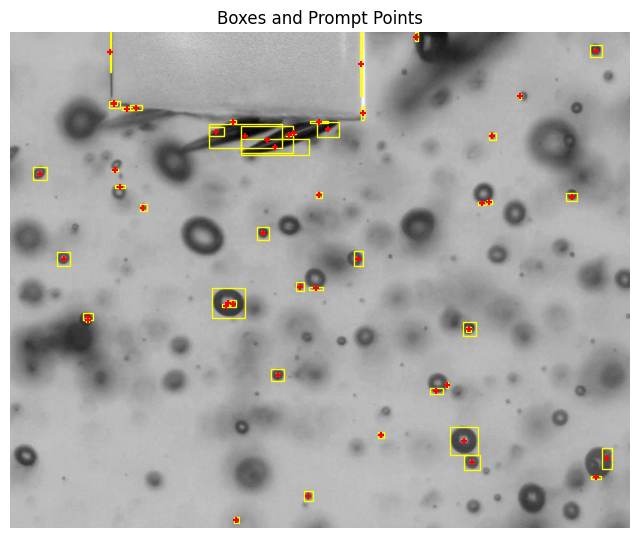

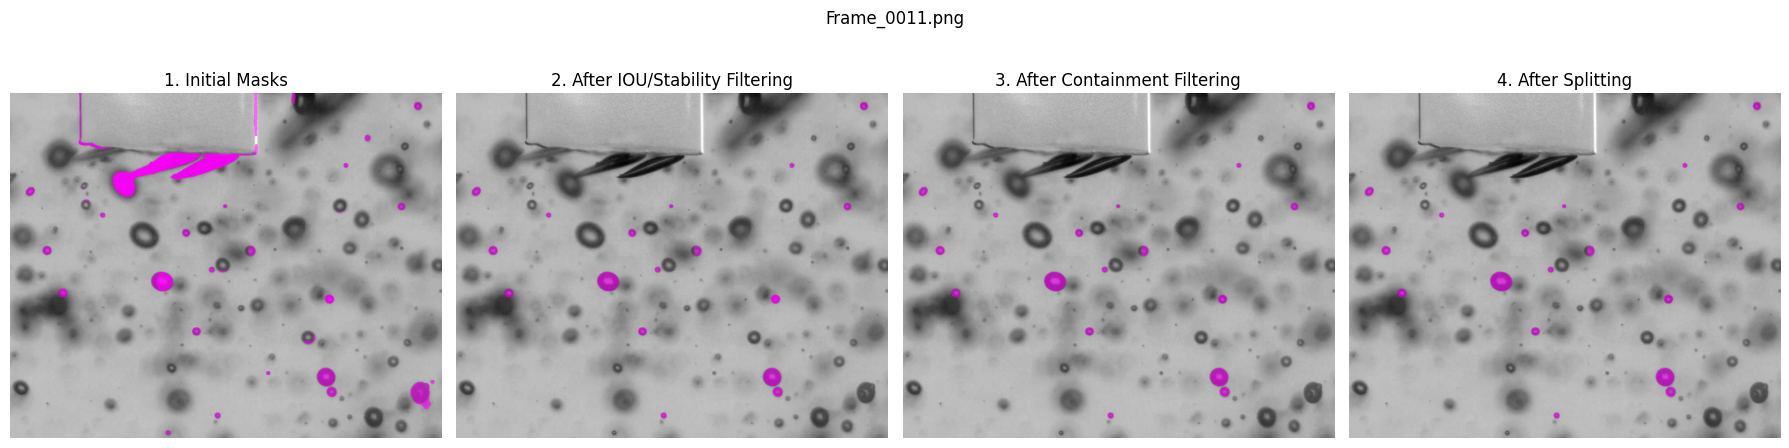

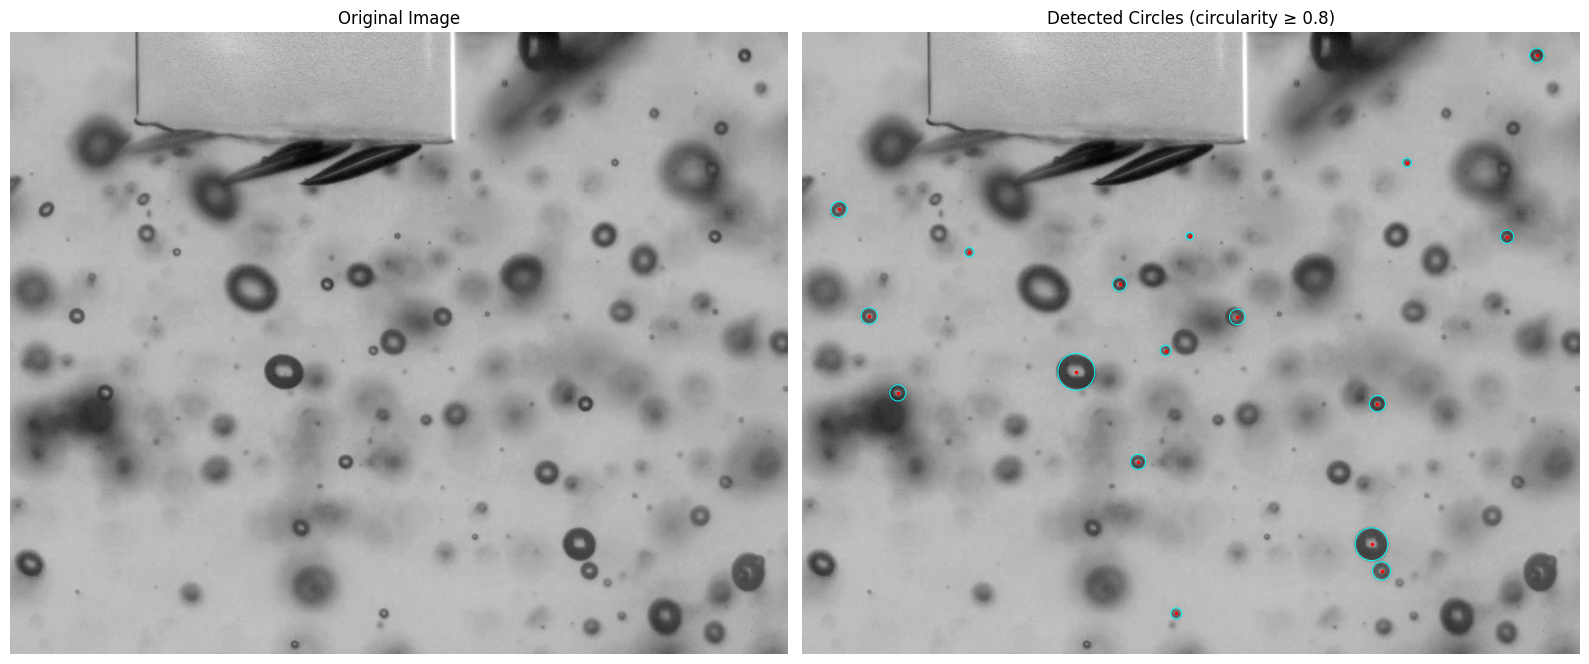

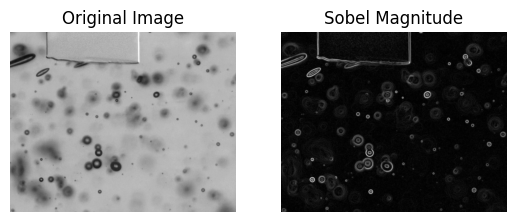

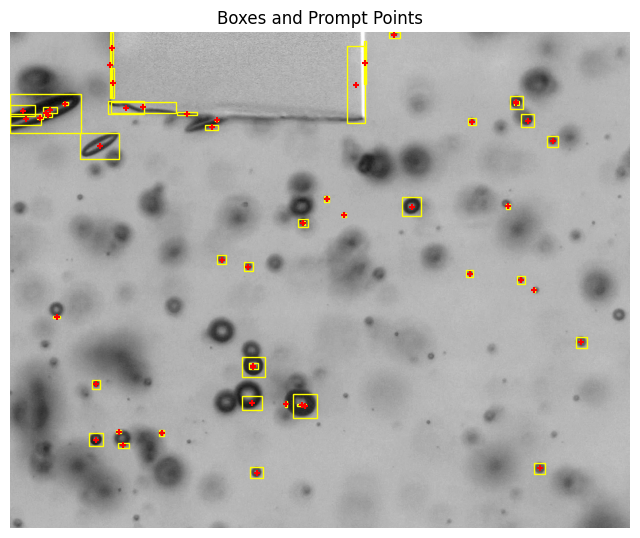

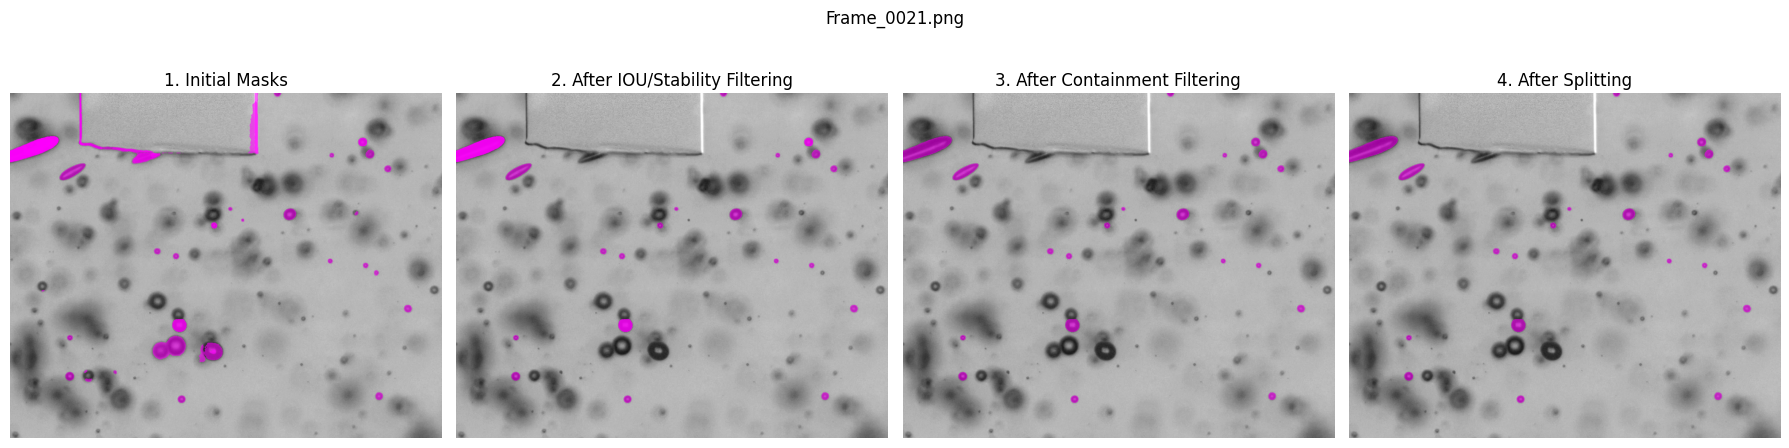

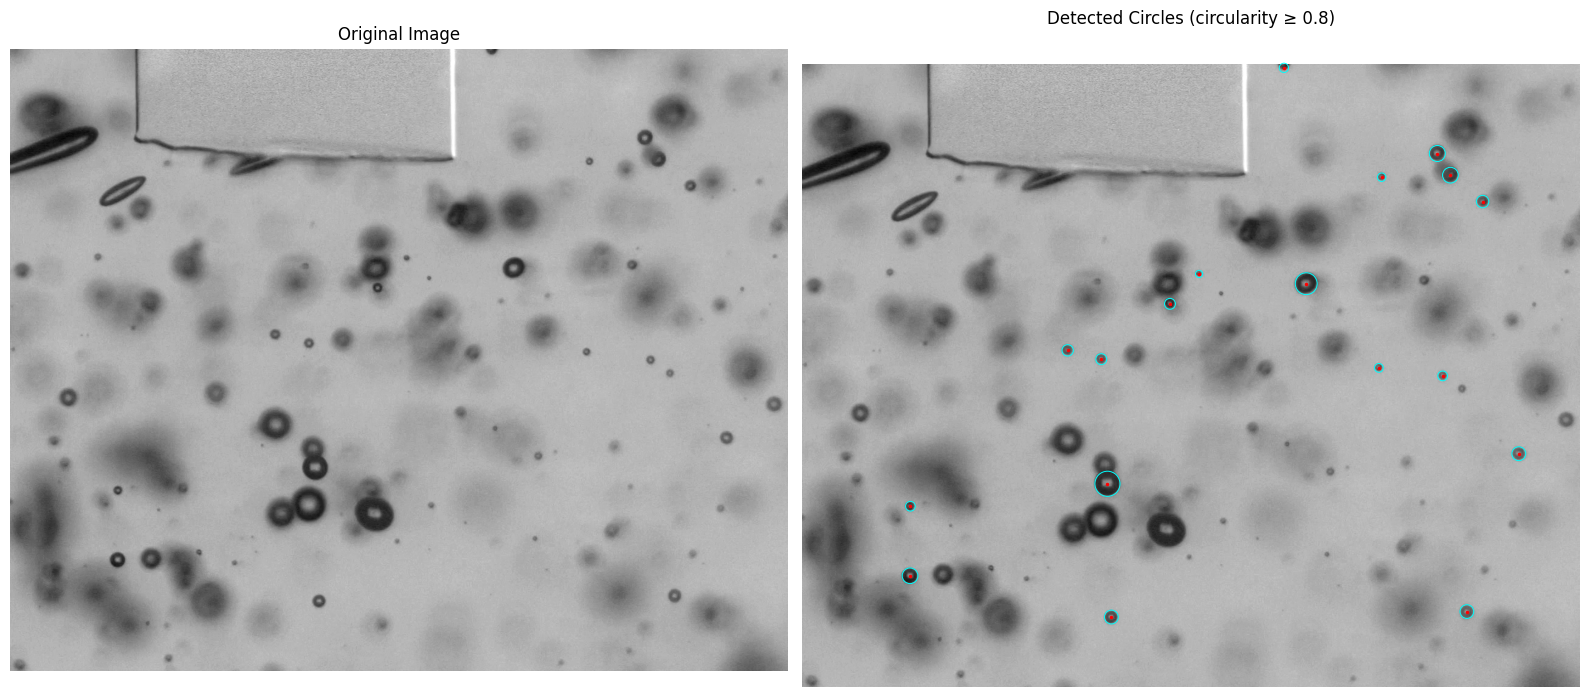

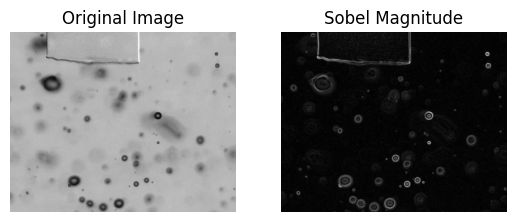

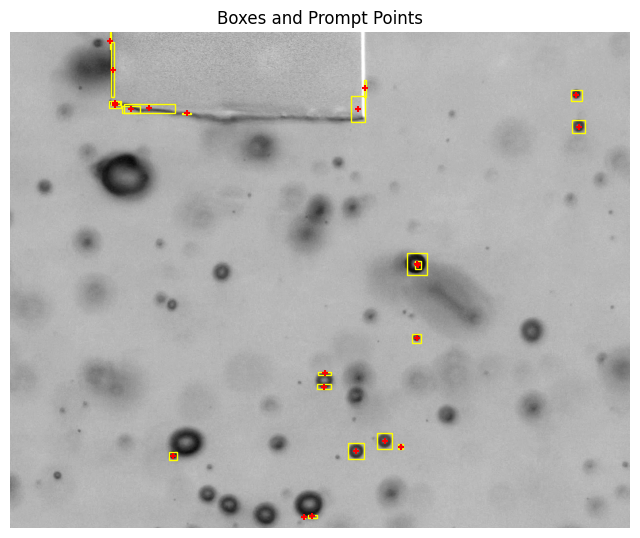

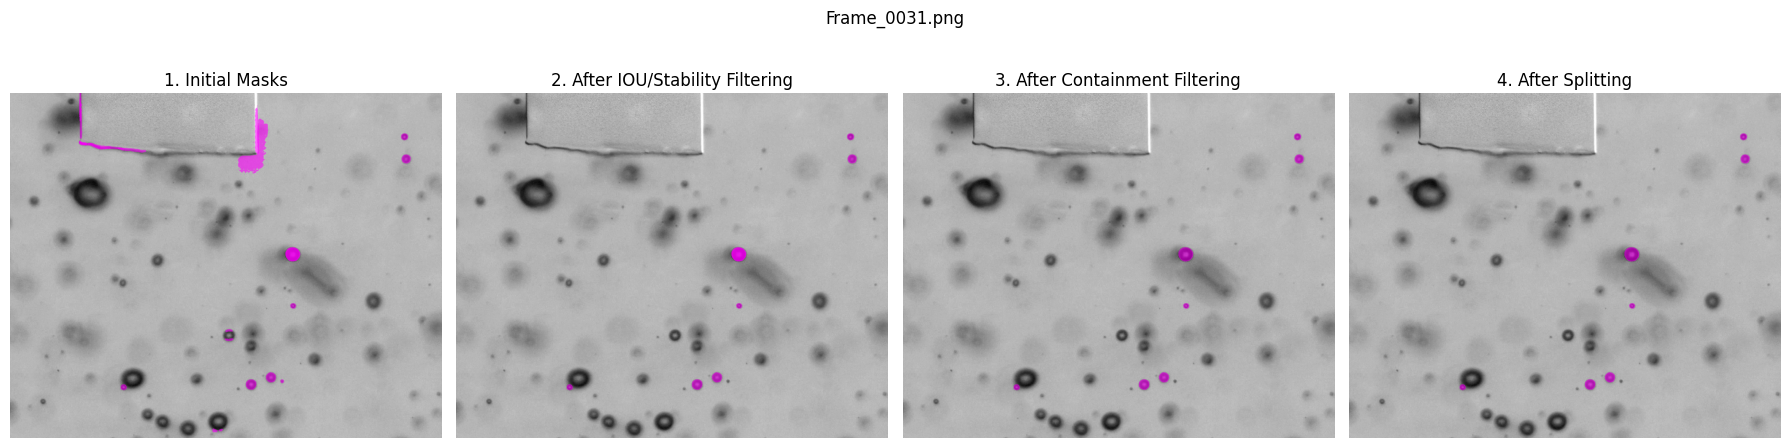

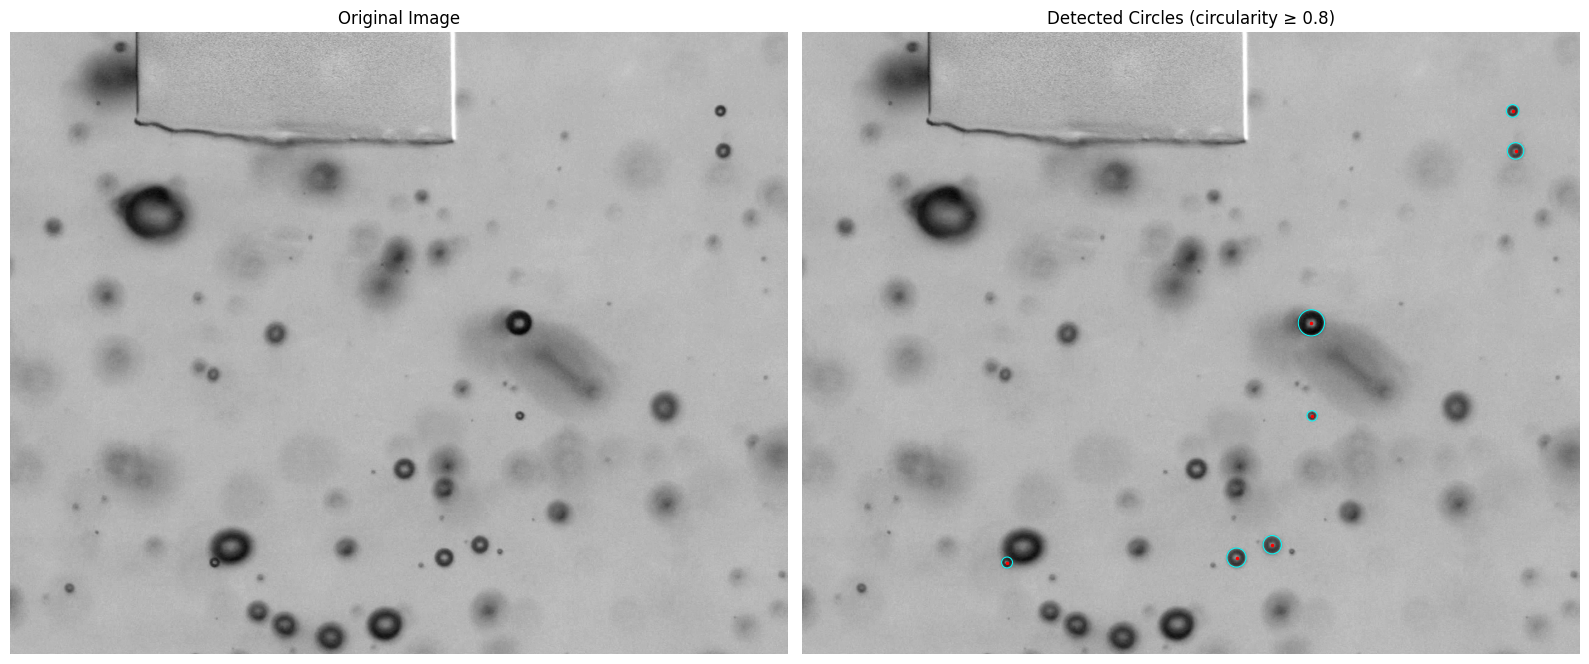

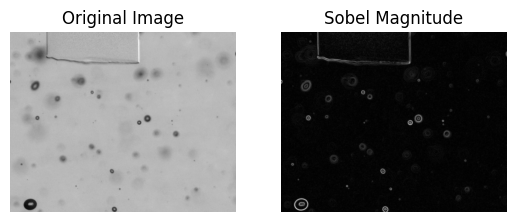

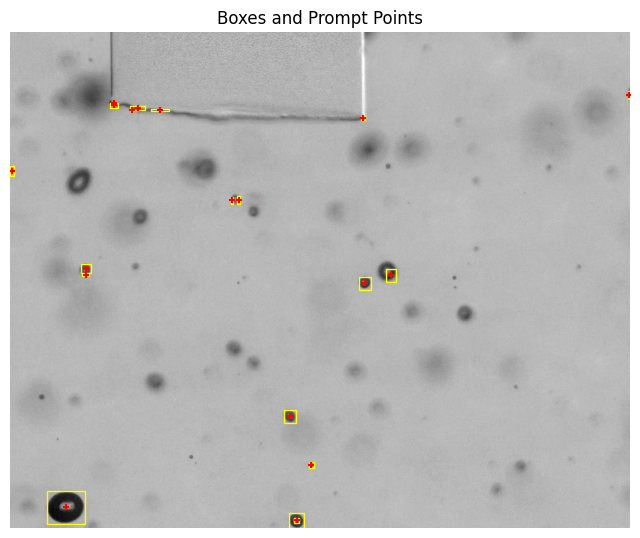

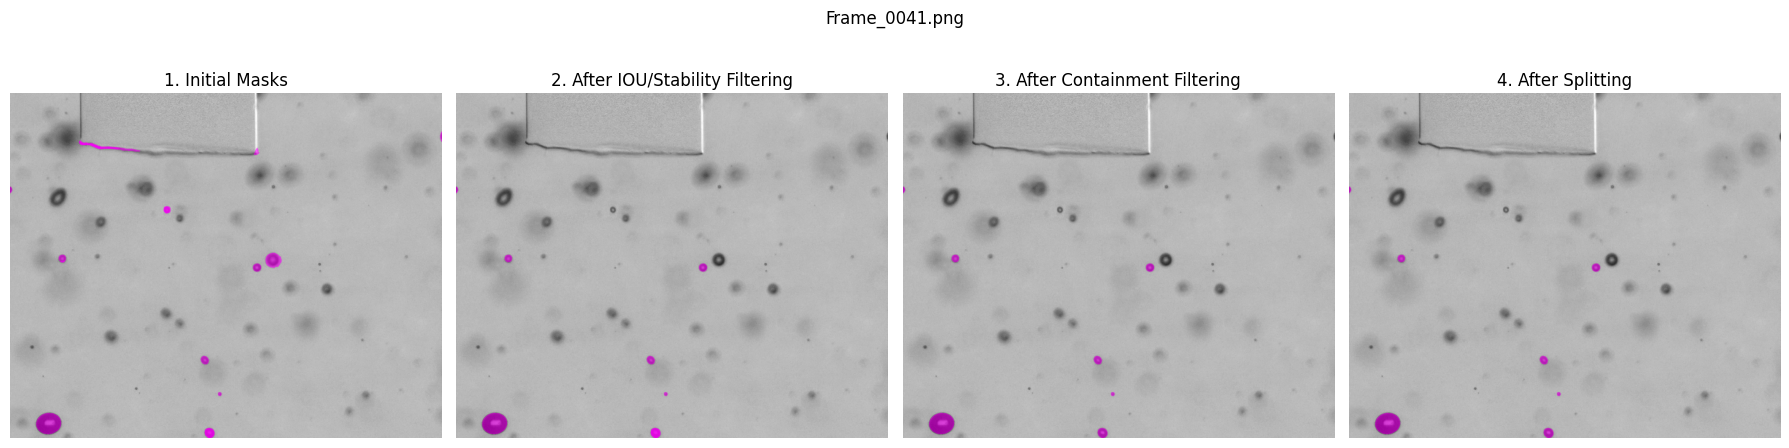

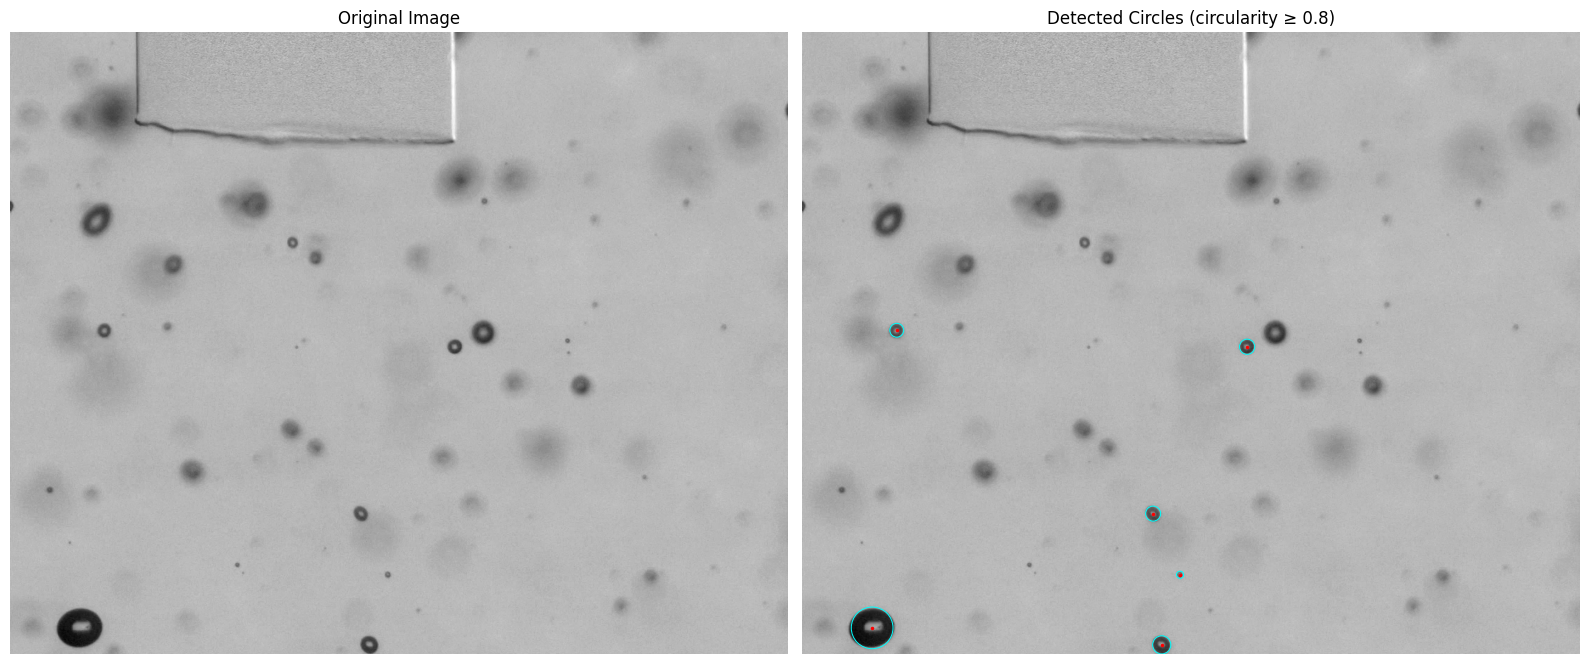

Through 5 frames
Reached test frame limit, stopping.
Finished processing 5 frames.
✔ Finished 1 of 1



In [79]:
test_mode=True;
test_mode_frames=5;
basePath = "/content/drive/MyDrive/Master's Data Processing/Thesis Data/"
flowRates = [1.5, 2.5, 3.5, 4.5, 5.5]
temps = [120, 180, 225]
angles = [7, 15, 30]
aeration_rates = [0.2]
trials = [1, 2]

basePath = "/content/drive/MyDrive/Master's Data Processing/Post-Thesis Data"
flowRates = [4.5]
temps = [180]
angles = [30]
aeration_rates = [0.2]
trials = [3]

model_choice = "tiny";
all_dirs = getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials)
sam2 = load_sam2_model(model_choice)
predictor = SAM2ImagePredictor(sam2, mask_threshold=0.7, max_hole_area=500, max_sprinkle_area=30)
start_index = 0
total = len(all_dirs)

for count, dir_path in enumerate(all_dirs[start_index:], start=start_index + 1):
    print(f"\nProcessing {count} of {total}: {dir_path}")
   # try:
    run_batch_on_experiments(
      dir_path,
      predictor,
      test_mode,
      test_mode_frames,
      iou_threshold,
      stability_threshold,
      peak_filter_size,
      min_region_area,
      max_region_area,
      edge_thresh,
      min_contour_len,
      pad_ratios)
    print(f"✔ Finished {count} of {total}\n")
    #except Exception as e:
    #print(f"❌ Failed on {dir_path} with error: {e}")



Found 90 valid directories out of 90 total combinations.


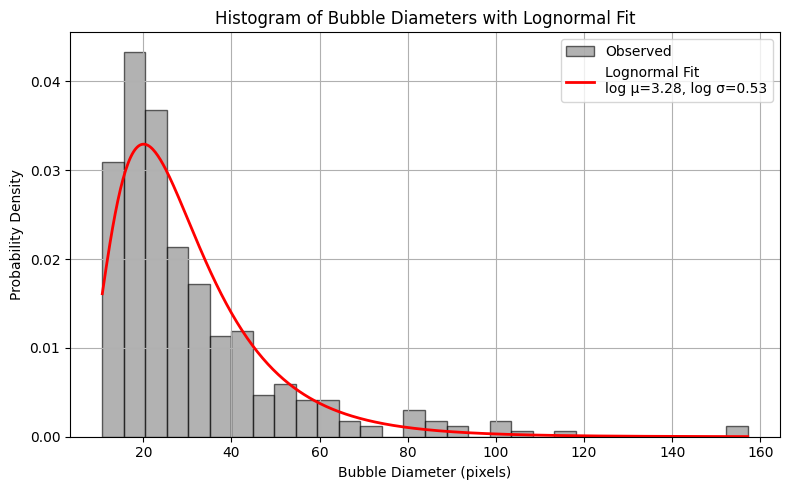

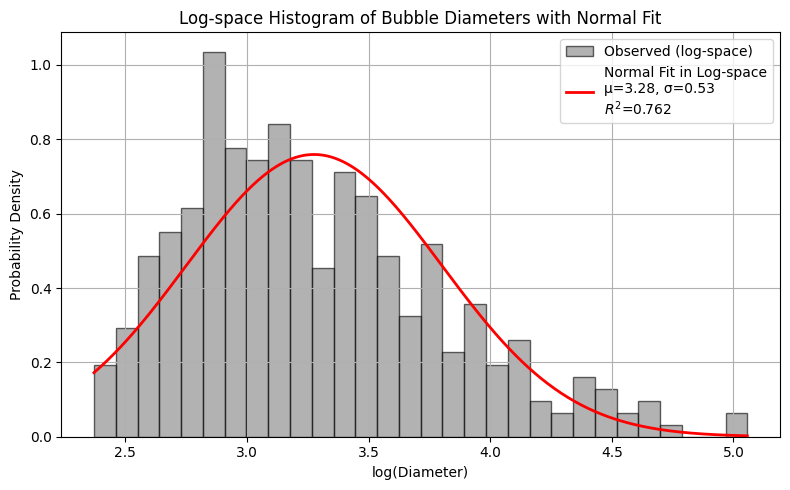

In [ ]:
basePath = "/content/drive/MyDrive/Master's Data Processing/Thesis Data/"
flowRates = [1.5, 2.5, 3.5, 4.5, 5.5]
temps = [120, 180, 225]
angles = [7, 15, 30]
aeration_rates = [0.2]
trials = [1, 2]

dirs = getDirectories(basePath, flowRates, temps, angles, aeration_rates, trials)
experiment_folder = dirs[2]

plot_diameter_histogram_from_summary(experiment_folder)
